In [1]:
from brian2 import *
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
set_device('cpp_standalone') #, build_on_run=False
start_scope()

def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0, 150])
    #ylim([0,1.5*np.max(rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()
    

In [2]:
warnings.filterwarnings('ignore')

eqs_adaptive = '''
du/dt = a*((b/mV)*v - u)/(1*ms) : 1

dv/dt = ( alpha*(v - U0)**2 /(mV) + Ubase - x*u*mV  - IsynE - IsynI)/(1*ms)  : volt # - (INaP)
alpha = 0.0125/3 : 1
U0 = -62.5*mV : volt
Ubase = -0*mV :volt
x = 0.06 : 1
a = 0.001/2 : 1 # interburst interval. The lesser the a, the greater IBI
b = 0.0: 1

IsynE = (gE*(wE_1+wE_2) + g_Edrive)*(v - v_synE): volt
gE = 0.1/3 : 1
g_Edrive = 0.1*(y) : 1 #exitatory drive #1*t/60000/ms
v_synE = -10*mV : volt
dwE_1/dt = -wE_1/tauE : 1
dwE_2/dt = -wE_2/tauE : 1
tauE = 10*ms : second

IsynI = gE*(wI_1 + wI_2 + wI_3 + wI_4)*(v - v_synI): volt
gI = 1 : 1
v_synI = -75*mV : volt
dwI_1/dt = -wI_1/tauI : 1
dwI_2/dt = -wI_2/tauI : 1
dwI_3/dt = -wI_3/tauI : 1
dwI_4/dt = -wI_4/tauI : 1
tauI = 15*ms : second
c = -55*mV   : volt 
d : 1
'''

eqs_bursting = '''
du/dt = a*((b/mV)*v - u)/(1*ms) : 1

dv/dt = ( alpha*(v - U0)**2 /(mV) + Ubase - 0.1*u*mV  - IsynE - IsynI)/(1*ms)  : volt # - (INaP)
alpha = 0.004 : 1
U0 = -62.5*mV : volt
Ubase = -1.6*mV :volt
a = 0.001 : 1 # interburst interval. The lesser the a, the greater IBI
b = 0.2: 1

IsynE = (gE*(wE_1+wE_2) + g_Edrive)*(v - v_synE): volt
gE = 0.1 : 1
g_Edrive = 0.1*(y) : 1 #exitatory drive #1*t/60000/ms
v_synE = -10*mV : volt
dwE_1/dt = -wE_1/tauE : 1
dwE_2/dt = -wE_2/tauE : 1
tauE = 10*ms : second

IsynI = gE*(wI_1 + wI_2 + wI_3 + wI_4)*(v - v_synI): volt
gI = 0.1 : 1
v_synI = -75*mV : volt
dwI_1/dt = -wI_1/tauI : 1
dwI_2/dt = -wI_2/tauI : 1
dwI_3/dt = -wI_3/tauI : 1
dwI_4/dt = -wI_4/tauI : 1
tauI = 15*ms : second
c = -50*mV   : volt #- (1*mV)*(u + 12.5)
d : 1
'''

eqs_LateE = eqs_bursting + ''' y =   1.4 + 0.3*(t/(50000*ms)) : 1'''
eqs_PreI = eqs_bursting + ''' y =  0.1 + 0.2 + 0.8 : 1'''
eqs_AugE = eqs_adaptive + ''' y =  0 + 1 + 0.9 : 1''' #0.7
eqs_EarlyI1 = eqs_adaptive + ''' y =  0 + 0.7 + 1.1 : 1'''
eqs_PostI = eqs_adaptive + ''' y =  0 + 0.05 + 1.75 : 1'''
eqs_PostI_e = eqs_adaptive + ''' y =  0 + 0.05 + 0.45 : 1'''
eqs_RampI = eqs_adaptive + ''' y =  0 + 0.0 + 1.5 : 1'''
eqs_EarlyI2 = eqs_adaptive + ''' y =  0 + 0.0 + 1.1 : 1'''
eqs_BulbE = eqs_adaptive + ''' y = 0.1 : 1'''



N = 500

PreI = NeuronGroup(N, eqs_PreI, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PreI.v  = -(30 + 0.70*rand(1,N))*mV
PreI.u  = (0 + 0.30*rand(1,N))*1
PreI.d = (+0.3 + 0.05*rand(1,N))

EarlyI1 = NeuronGroup(N, eqs_EarlyI1, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
EarlyI1.d  = (+0.5 + 0.05*rand(1,N))*1
EarlyI1.v  = -(30 + 0.70*rand(1,N))*mV
EarlyI1.u  = (0 + 0.30*rand(1,N))*1

AugE = NeuronGroup(N, eqs_AugE, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
AugE.d  = (+0.5 + 0.05*rand(1,N))*1
AugE.v  = -(30 + 0.70*rand(1,N))*mV
AugE.u  = (0 + 0.30*rand(1,N))*1

PostI = NeuronGroup(N, eqs_PostI, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PostI.d  = (+0.5 + 0.05*rand(1,N))*1
PostI.v  = -(30 + 0.70*rand(1,N))*mV
PostI.u  = (0 + 0.30*rand(1,N))*1

PostI_e = NeuronGroup(N, eqs_PostI_e, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PostI_e.d  = (+0.5 + 0.05*rand(1,N))*1
PostI_e.v  = -(30 + 0.70*rand(1,N))*mV
PostI_e.u  = (0 + 0.30*rand(1,N))*1

RampI = NeuronGroup(N, eqs_RampI, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
RampI.d  = (+0.5 + 0.05*rand(1,N))*1
RampI.v  = -(30 + 0.70*rand(1,N))*mV
RampI.u  = (0 + 0.30*rand(1,N))*1

EarlyI2 = NeuronGroup(N, eqs_EarlyI2, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
EarlyI2.d  = (+0.5 + 0.05*rand(1,N))*1
EarlyI2.v  = -(30 + 0.70*rand(1,N))*mV
EarlyI2.u  = (0 + 0.30*rand(1,N))*1

LateE = NeuronGroup(N, eqs_LateE, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
LateE.v  = -(30 + 0.70*rand(1,N))*mV
LateE.u  = (0 + 0.30*rand(1,N))*1
LateE.d = (+0.3 + 0.05*rand(1,N))

BulbE = NeuronGroup(N, eqs_BulbE, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
BulbE.d  = (+0.5 + 0.05*rand(1,N))*1
BulbE.v  = -(30 + 0.70*rand(1,N))*mV
BulbE.u  = (0 + 0.30*rand(1,N))*1

#connecting populations
PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_1_post += 0.25*0.01*(1+(0.1 * randn()))') 
PreI_PreI.connect(p=0.4, condition = 'i!=j')

PreI_EarlyI1 = Synapses(PreI, EarlyI1,  on_pre='wE_1_post += 0.25*0.05*(1+(0.1 * randn()))') 
PreI_EarlyI1.connect(p=0.4)

AugE_PreI = Synapses(AugE, PreI,  on_pre='wI_2_post += 0.25*0.01*(1+(0.1 * randn()))') 
AugE_PreI.connect(p=0.4)

# PreI_AugE = Synapses(PreI,AugE,  on_pre='wI_3_post += 0.001') 
# PreI_AugE.connect(p=1)


AugE_EalyI1 = Synapses(AugE, EarlyI1,  on_pre='wI_1_post += 0.25*0.08*(1+(0.1 * randn()))') 
AugE_EalyI1.connect(p=0.4)

EarlyI1_AugE = Synapses(EarlyI1, AugE,  on_pre='wI_1_post += 0.25*0.09*(1+(0.1 * randn()))') 
EarlyI1_AugE.connect(p=0.4)
################################

PostI_EarlyI1 = Synapses(PostI, EarlyI1,  on_pre='wI_2_post += 0.25*0.08*(1+(0.1 * randn()))') 
PostI_EarlyI1.connect(p=0.4)

PostI_AugE = Synapses(PostI, AugE,  on_pre='wI_2_post += 0.25*0.085*(1+(0.1 * randn()))') 
PostI_AugE.connect(p=0.4)

EarlyI1_PostI = Synapses(EarlyI1, PostI,  on_pre='wI_1_post += 0.25*0.08*(1+(0.1 * randn()))') 
EarlyI1_PostI.connect(p=0.4)

AugE_PostI = Synapses(AugE, PostI,  on_pre='wI_2_post += 0.25*0.02*(1+(0.1 * randn()))') 
AugE_PostI.connect(p=0.4)

PostI_PreI = Synapses(PostI, PreI,  on_pre='wI_1_post += 0.25*0.02*(1+(0.1 * randn()))') 
PostI_PreI.connect(p=0.4)

# AugE_AugE = Synapses(AugE, AugE,  on_pre='wE_post += 0.03') 
# AugE_AugE.connect(p=1, condition = 'i!=j')


#####################################
AugE_PostI_e = Synapses(AugE, PostI_e, on_pre='wI_1_post += 0.25*0.02*(1+(0.1 * randn()))') 
AugE_PostI_e.connect(p=0.4)

EarlyI1_PostI_e = Synapses(EarlyI1, PostI_e, on_pre='wI_2_post += 0.25*0.08*(1+(0.1 * randn()))') 
EarlyI1_PostI_e.connect(p=0.4)

PreI_RampI = Synapses(PreI, RampI, on_pre='wE_1_post += 0.25*0.04*(1+(0.1 * randn()))') 
PreI_RampI.connect(p=0.4)

AugE_RampI = Synapses(AugE, RampI, on_pre='wI_1_post += 0.25*0.14*(1+(0.1 * randn()))') 
AugE_RampI.connect(p=0.4)

PostI_RampI = Synapses(PostI, RampI, on_pre='wI_2_post += 0.25*0.095*(1+(0.1 * randn()))') 
PostI_RampI.connect(p=0.4)

EarlyI2_RampI = Synapses(EarlyI2, RampI, on_pre='wI_3_post += 0.25*0.08*(1+(0.1 * randn()))') 
EarlyI2_RampI.connect(p=0.4)

AugE_EarlyI2 = Synapses(AugE, EarlyI2, on_pre='wI_1_post += 0.25*0.08*(1+(0.1 * randn()))') 
AugE_EarlyI2.connect(p=0.4)

PostI_EarlyI2 = Synapses(PostI, EarlyI2, on_pre='wI_2_post += 0.25*0.08*(1+(0.1 * randn()))') 
PostI_EarlyI2.connect(p=0.4)

#####################################
LateE_PreI = Synapses(LateE, PreI, on_pre='wE_2_post += 0.25*0.01*(1+(0.1 * randn()))') 
LateE_PreI.connect(p=0.4)

LateE_LateE = Synapses(LateE, LateE, on_pre='wE_1_post += 0.25*0.03*(1+(0.1 * randn()))') 
LateE_LateE.connect(p=0.4)


EarlyI1_LateE = Synapses(EarlyI1, LateE, on_pre='wI_1_post += 0.25*0.03*(1+(0.1 * randn()))') 
EarlyI1_LateE.connect(p=0.4)

PostI_LateE = Synapses(PostI, LateE, on_pre='wI_2_post += 0.25*0.025*(1+(0.1 * randn()))') 
PostI_LateE.connect(p=0.4)


LateE_AugE = Synapses(LateE, AugE, on_pre='wE_1_post += 0.25*0.02*(1+(0.1 * randn()))') 
LateE_AugE.connect(p=0.4)

LateE_EarlyI2 = Synapses(LateE, EarlyI2, on_pre='wE_1_post += 0.25*0.03*(1+(0.1 * randn()))') 
LateE_EarlyI2.connect(p=0.4)

LateE_BulbE = Synapses(LateE, BulbE, on_pre='wE_1_post += 0.25*0.07*(1+(0.1 * randn()))') 
LateE_BulbE.connect(p=0.4)

EarlyI2_BulbE = Synapses(EarlyI2, BulbE, on_pre='wI_1_post += 0.25*0.09*(1+(0.1 * randn()))') 
EarlyI2_BulbE.connect(p=0.4)

rcrd = False

#monitorings, spikes etc.
PreI_statemon = StateMonitor(PreI, ['v','wE_1','wE_2','wI_1','wI_2','wI_3'], record = rcrd)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)

EarlyI1_statemon = StateMonitor(EarlyI1, ['v','wE_1','wE_2','wI_1','wI_2','wI_3'], record = rcrd)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)

AugE_statemon = StateMonitor(AugE, ['v','wE_1','wE_2','wI_1','wI_2','wI_3'], record = rcrd)
AugE_spikemon = SpikeMonitor(AugE)
AugE_rate = PopulationRateMonitor(AugE)

PostI_statemon = StateMonitor(PostI, ['v','wE_1','wE_2','wI_1','wI_2','wI_3'], record = rcrd)
PostI_spikemon = SpikeMonitor(PostI)
PostI_rate = PopulationRateMonitor(PostI)

EarlyI2_statemon = StateMonitor(EarlyI2, ['v','wE_1','wE_2','wI_1','wI_2','wI_3'], record = rcrd)
EarlyI2_spikemon = SpikeMonitor(EarlyI2)
EarlyI2_rate = PopulationRateMonitor(EarlyI2)

RampI_statemon = StateMonitor(RampI, ['v','wE_1','wE_2','wI_1','wI_2','wI_3'], record = rcrd)
RampI_spikemon = SpikeMonitor(RampI)
RampI_rate = PopulationRateMonitor(RampI)

PostI_e_statemon = StateMonitor(PostI_e, ['v','wE_1','wE_2','wI_1','wI_2','wI_3'], record = rcrd)
PostI_e_spikemon = SpikeMonitor(PostI_e)
PostI_e_rate = PopulationRateMonitor(PostI_e)

LateE_statemon = StateMonitor(LateE, ['v','wE_1','wE_2','wI_1','wI_2','wI_3','y'], record = rcrd)
LateE_spikemon = SpikeMonitor(LateE)
LateE_rate = PopulationRateMonitor(LateE)

BulbE_statemon = StateMonitor(BulbE, ['v','wE_1','wE_2','wI_1','wI_2','wI_3'], record = rcrd)
BulbE_spikemon = SpikeMonitor(BulbE)
BulbE_rate = PopulationRateMonitor(BulbE)

##
#running the simulation


duration = 50000
run(duration*ms, report='text')
# device.build(directory='output', compile=True, run=True, debug=False)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.06s, trying other methods took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.04s, trying other methods took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.04s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.04s, trying other methods took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'euler' (took 0.04s, trying other methods took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specifi

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "wI_1_post += 0.0225 * (1.0 + (0.1 * randn())) (in-place)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "wI_2_post += 0.02 * (1.0 + (0.1 * randn())) (in-place)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 2 lines of abstract code, first line is: "wI_2_post += 0.02125 * (1.0 + (0.1 * randn()

In [3]:
n = 0.0
m = 1.0

PostI


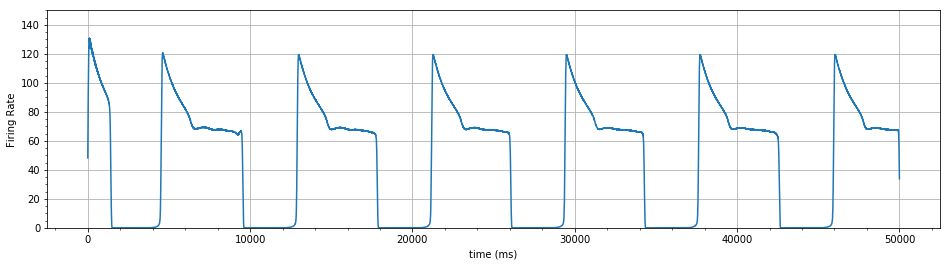

AugE


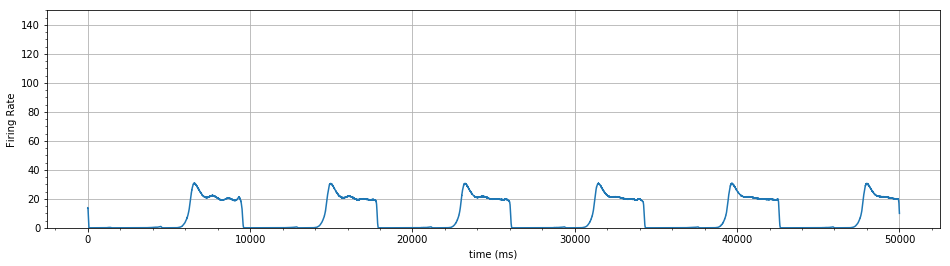

EarlyI1


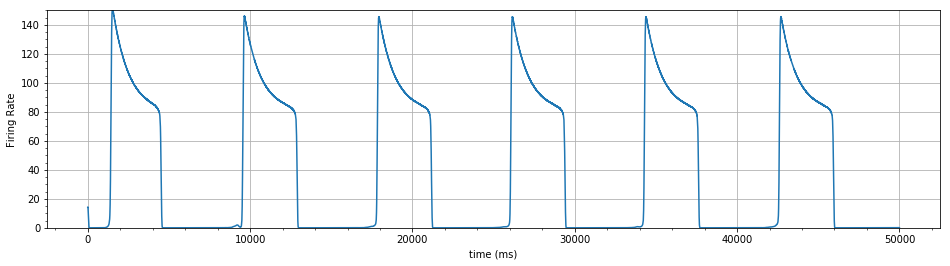

PreI


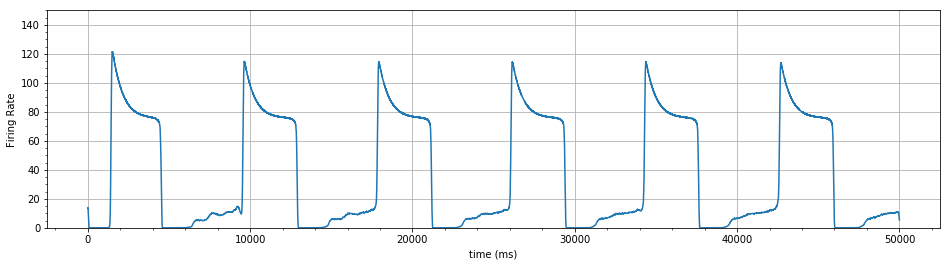

RampI


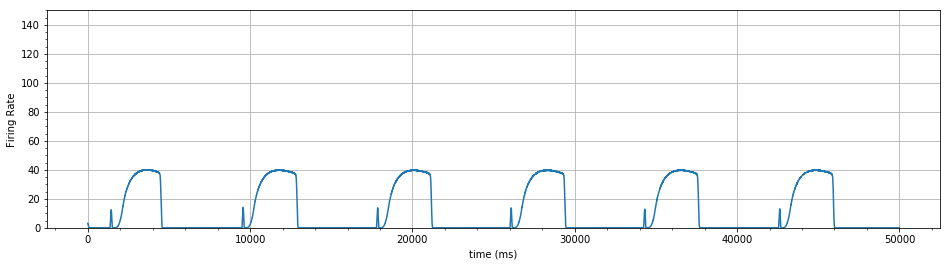

EarlyI2


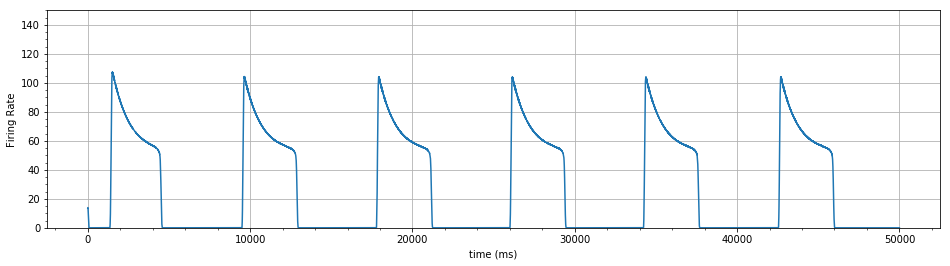

PostI_e


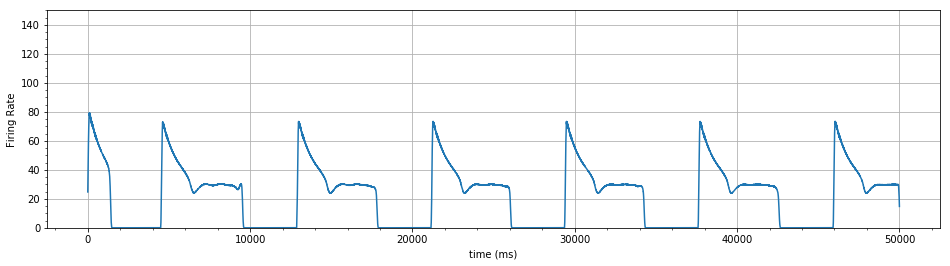

BulbE


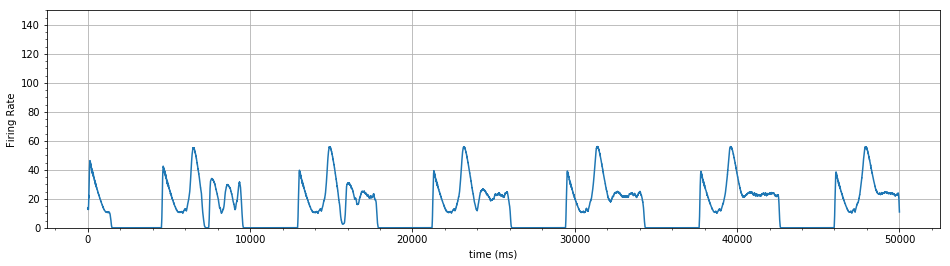

LateE


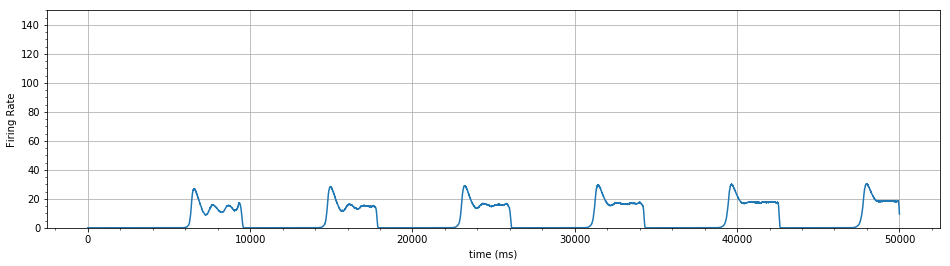

In [4]:
print("PostI")
plot_vars(PostI_statemon, PostI_rate, n, m, show_variables = False)
print("AugE")
plot_vars(AugE_statemon, AugE_rate,  n, m, show_variables = False)
print("EarlyI1")
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = False)
print("PreI")
plot_vars(PreI_statemon, PreI_rate, n, m, show_variables = False)
print("RampI")
plot_vars(RampI_statemon, RampI_rate,  n, m, show_variables = False)
print("EarlyI2")
plot_vars(EarlyI2_statemon, EarlyI2_rate,  n, m, show_variables = False)
print("PostI_e")
plot_vars(PostI_e_statemon, PostI_e_rate, n, m, show_variables = False)
print("BulbE")
plot_vars(BulbE_statemon, BulbE_rate, n, m, show_variables = False)
print("LateE")
plot_vars(LateE_statemon, LateE_rate, n, m, show_variables = False)

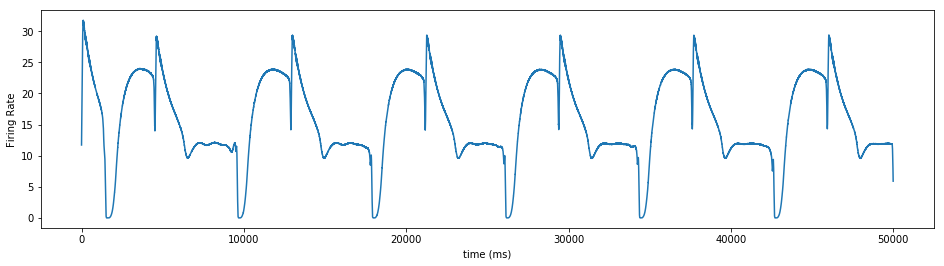

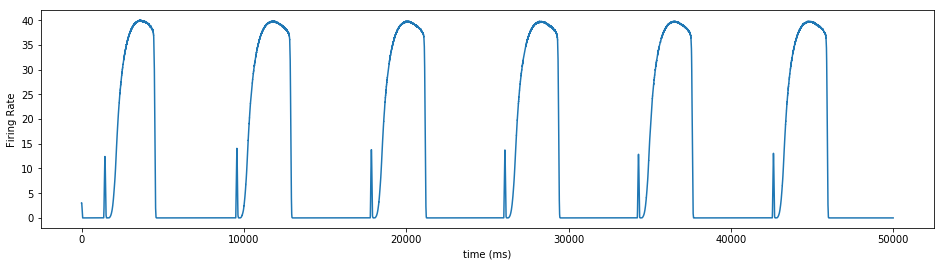

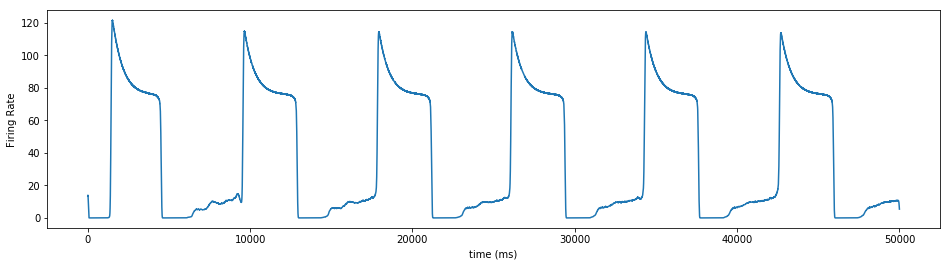

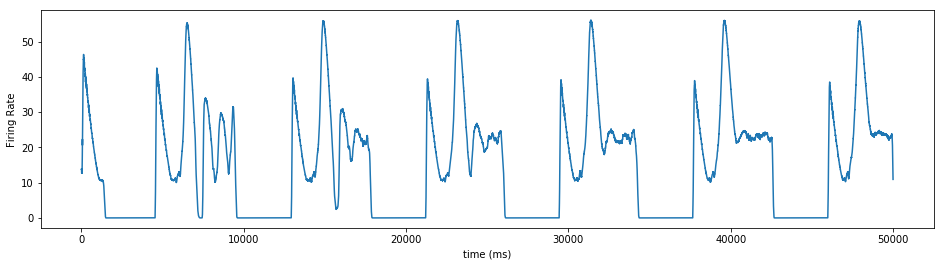

In [5]:
#CVN
#2/3 PostI_e 1/3 rampI
output_cVN = (2.0/5.0)*PostI_e_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz+(3.0/5.0)*RampI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_cVN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

#PN
output_PN = RampI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_PN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

#HN
output_HN = PreI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_HN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

#AbN
output_AbN = BulbE_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_AbN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()
